# Класстеризация текста (тестовое задание greenatom)

**Подключим необходимые библиотеки, а также напишем план действий, которые мы будем совершать**:
   
- Загрузка текста, его анализ и обработка.
- Выбор baseline модели.
- Подбор гиперпараметров.
- Результаты и вывод.

In [1]:
#Для визуализации
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

#Для дополнительной информации
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

#Для класстеризации
from sklearn.cluster import OPTICS, AffinityPropagation, KMeans
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_extraction.text import  TfidfVectorizer

#Для получения эмбеддингов
import torch
from transformers import AutoTokenizer, AutoModel, MBartTokenizer, MBartForConditionalGeneration
import fasttext 

#Для обработки текста
from nltk import sent_tokenize, word_tokenize, regexp_tokenize
import pymorphy2
from deeppavlov import build_model, configs
import string

spellmodel = build_model('levenshtein_corrector_ru', download=False)

In [2]:
data = pd.read_csv('data.csv')

In [4]:
data = data[['qid', 'label']]
data.head()

,qid,label
0,55983,азарт
1,55983,актианость
2,55983,активность
3,55983,проявление активности
4,55983,быть в команде


Взглянем на наши данные - два опроса и ответы пользователей. В ответах пользователей ~~часто~~ содержатся ошибки. 


Класстеризацию текстов будем проводить вместе. 

(*Т.е. на самом деле задача: есть опрос, разобьем ответы на смысловые группы. Можно разделить наши опросы и по ним класстеризовать ответы, программа универсальна, так что это делается изменением в паре строчек кода*)

## Обработка текста

Для начала исправим ответы пользователей:
 - Воспользуемся spellchecker'ом для  исправления ошибок текста
 - Приведем слова в тексте к нижнему регистру, удалим пунктуацию (в данном задаче она нам ни к чему)
 - Приведем слова в тексте к нормальной форме (лемминг)

In [243]:
def normalize_tokens(tokens):
    morph = pymorphy2.MorphAnalyzer()
    return [morph.parse(tok)[0].normal_form for tok in tokens]

def text_lower(text):
    return text.lower()

def text_remove_punct(text):
    text_no_punct = text.translate(str.maketrans('', '', string.punctuation))
    return text_no_punct

def text_strip(text):
    return text.strip()

def lemmatize(text, normalize=True, regexp=r'(?u)\b\w{4,}\b'):
    words = [w for sent in sent_tokenize(text)
             for w in regexp_tokenize(sent, regexp)]
    if normalize:
        words = normalize_tokens(words)
    return " ".join(words)

def spellcheck(text):
    text = spellmodel([text])
    return text[0]


In [244]:
def text_preprocess(text):
    text = text_lower(text)
    text = text_strip(text)
    text = text_remove_punct(text)
    text = lemmatize(text)
    text = spellcheck(text)
    return text

Почистим текст, некоторые ответы совсем не имели смысла, так что их мы удалим после обработки.

In [245]:
data['clear_text'] = data['label'].apply(text_preprocess)
new_data = data[data['clear_text'].map(len) != 0]

In [1018]:
'''
Если хотим разделить данные:
qids = list(set(new_data['qid'].to_list()))
q0 = new_data[new_data['qid'] == qids[0]].reset_index(drop=True)
q1 = new_data[new_data['qid'] == qids[1]].reset_index(drop=True)
'''

"\nЕсли хотим разделить данные:\nqids = list(set(new_data['qid'].to_list()))\nq0 = new_data[new_data['qid'] == qids[0]].reset_index(drop=True)\nq1 = new_data[new_data['qid'] == qids[1]].reset_index(drop=True)\n"

## Baseline модель 
Для кластеризации возьмем KMeans как baseline модель, в силу ее простоты и понятной работы.
Для представления векторов возьмем tf-idf по тем же причинам.

In [811]:
tf = TfidfVectorizer(ngram_range=(1,1), norm='l2')
X = tf.fit_transform(new_data['clear_text'])
tsvd = TruncatedSVD(n_components=X.shape[0])
X_tsvd = tsvd.fit(X)
plt.plot(np.cumsum(tsvd.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

Как видно, можно сократить размер векторов ~120, мы не потеряем сильно в размерности векторов, но это немного поможет с разряженностью.

In [855]:
tsvd = TruncatedSVD(n_components=120, random_state=40)
X_tsvd = tsvd.fit_transform(X)

Воспользуемся методом локтя для определения количества класстеров:

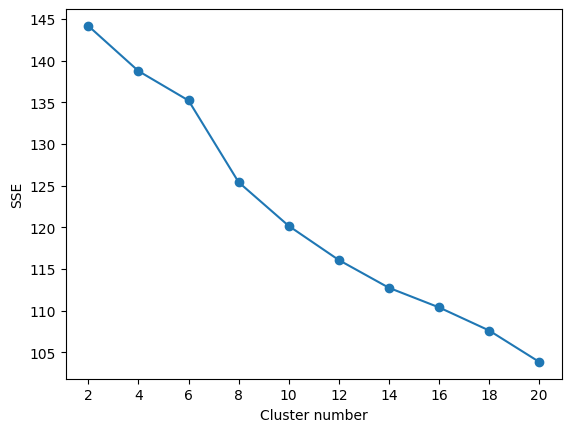

In [856]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(KMeans(n_clusters=k, random_state=40).fit(data).inertia_)
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster number')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    
find_optimal_clusters(X_tsvd, 20)

**Мое мнение**: локоть на 8 - 10, немного поигравшись (рассматривал кластеры и их ~~осмысленность~~), я понял, что вариант 8 кластеров устраивает меня больше других вариантов.

In [1001]:
num_clusters = 8
clusters = KMeans(n_clusters=num_clusters, random_state=40).fit_predict(X_tsvd)
new_data['cluster_by_baseline'] = clusters
for i, c in enumerate(set(clusters)):
    print('\nCluster {}'.format(i))
    print(set(" ".join(new_data[new_data['cluster_by_baseline'] == c][:5]['clear_text'].tolist()).split()))
        

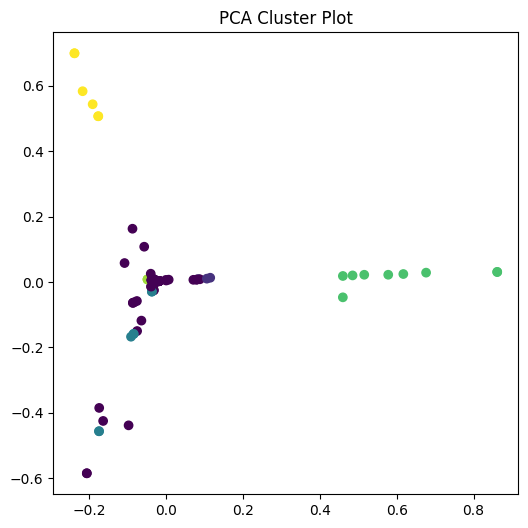

In [1005]:
def plot_pca(data, labels):
    pca = PCA(n_components=2, random_state=40).fit_transform(data)
    f, ax = plt.subplots(1, 1, figsize=(6, 6))

    ax.scatter(pca[:, 0], pca[:, 1], c=labels)
    ax.set_title('PCA Cluster Plot')
    
plot_pca(X_tsvd, clusters)

## Основная модель (fasttext, Sentence Transformers)

In [879]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
model = AutoModel.from_pretrained("cointegrated/LaBSE-en-ru")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/521k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/516M [00:00<?, ?B/s]

tensor([[-0.0714, -0.0772, -0.0305,  ...,  0.0136, -0.0402, -0.0245],
        [-0.0644, -0.0687, -0.0521,  ...,  0.0139, -0.0362, -0.0213]])


Для начала попробуем использовать предобученные sentence-based эмбеддинги для наших предложений, вполне вероятно, что таким образом мы получим *более осмысленные* кластеры

In [924]:
def get_labse_sentence(sentence):
    encoded_input = tokenizer(sentence, padding=True, truncation=True, max_length=64, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
        embedding = model_output.pooler_output
        embedding = torch.nn.functional.normalize(embedding)
    return embedding
new_data['snt_tr_emb'] = new_data['clear_text'].apply(get_labse_sentence)

Для выбора основных моделей класстеризации я взял OPTICS, AffinityPropagation и всеми любимый KMeans.

In [1159]:
def checkmodel(df, data, method, name, verbose=False, maxterms=3, cluster_num=20):
    name = f'cluster_by_{name}'
    if method == 'optics':
        if verbose:
            for k in range(1, 4):
                for mins in range(2, 5):
                    model = OPTICS(p=k, min_samples=mins)
                    model.fit(data)
                    yhat = model.labels_
                    df[name] = yhat
                    print(f"Num of clusters: {len(set(yhat))}\n Model config: {model}")
        model = OPTICS(p=3, min_samples=2)
        model.fit(data)
        yhat = model.labels_
        df[name] = yhat
                
    if method == 'affinity':
        model = AffinityPropagation(random_state=40)
        model.fit(data)
        yhat = model.labels_
        df[name] = yhat
        print(f"Num of clusters: {len(set(yhat))}\n Model config: {model}")
    
    if method == 'kmeans':
        if verbose:
            find_optimal_clusters(data, 40)
        yhat = KMeans(n_clusters=cluster_num, random_state=40).fit_predict(data)
        df[name] = yhat
        
    if verbose:
        print(yhat)
        plot_pca(data, yhat)
        for i, c in enumerate(set(yhat)):
            print('\nCluster {}'.format(c))
            print(set(" ".join(df[df[name] == c][:maxterms]['clear_text'].tolist()).split()))
                        

In [1023]:
X_bert = np.vstack(new_data['snt_tr_emb'])

Теперь попробуем с FastText эмбеддинги:

In [1042]:
fsttxt = fasttext.load_model("cc.ru.300.bin")
def get_fsttxt_sentence(sentence):
    return fsttxt.get_sentence_vector(sentence)
new_data['fsttxt_emb'] = new_data['clear_text'].apply(get_fsttxt_sentence)

In [1063]:
X_fsttxt = np.vstack(new_data['fsttxt_emb'])

Теперь исследуем модели, найдем удовлетворяющие нас результаты. (с метода checkmodel будем подбирать гиперпараметры, а verbose поможет оценивать их подбор)

[10  4  4  4 16 15 16  3 10  4 17 17 15 11  6 15 11  1 16 15 15 15 15 15
  9  0  4  4  4  4  5  5  5 15  4 10 10  5  6 16  9  1  1  3 12  9  9  9
 15  9  9  4  4 16 16  5  8  6  9  0  0  0 16 16  4  3  0 17 18  4 16 15
 15 12 14 14 14 10  0 15 12  1  9  0  0 11 11  3  3  9  4  3  2 16  7  7
 16 12 15 12 16  6  6 16  6 16 16 15 16 16 16 16 12 12 12 16  2  2  2  6
 17 15  7  6 11 16 16  7 16  7  7  3 16  3 19 19 19 16 13 12 17  4 12 12
  9  2  7 16 10 12 16]

Cluster 0
{'погружение', 'дело', 'отдача', 'задача', 'деталь', 'знание'}

Cluster 1
{'компания', 'доверие', 'лояльность'}

Cluster 2
{'много', 'вариант', 'вдруг', 'плохо', 'риск'}

Cluster 3
{'вдохновение', 'дело', 'признание', 'любовь', 'свой'}

Cluster 4
{'проявление', 'активность'}

Cluster 5
{'дело', 'интерес'}

Cluster 6
{'исполнительность', 'ответственность', 'готовность'}

Cluster 7
{'неизвестность', 'боязнь', 'ошибка', 'ошибиться'}

Cluster 8
{'оставаться'}

Cluster 9
{'заинтересованность', 'нацеленность', 'результат', 'кома

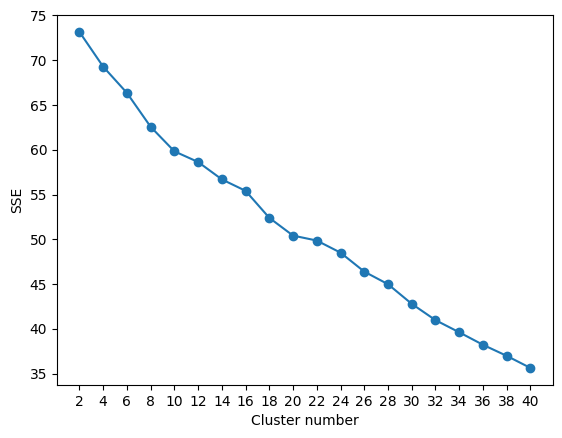

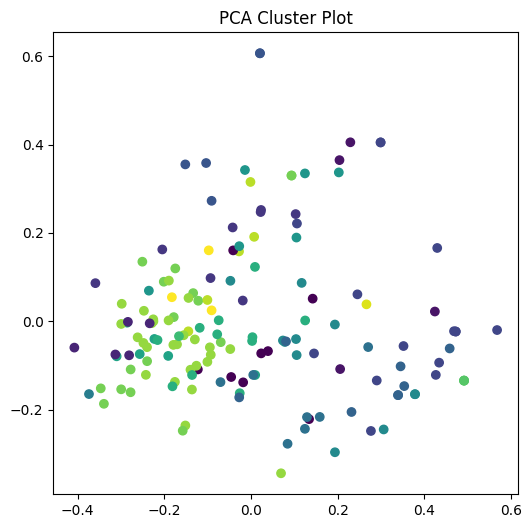

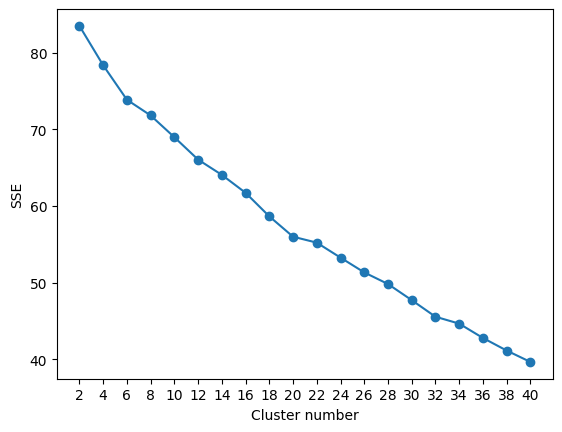

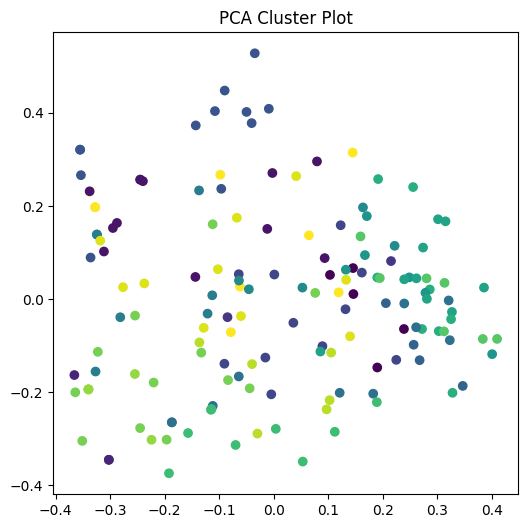

In [1076]:
'''
checkmodel(new_data, X_fsttxt, "optics", "fsttxt", verbose=True)
checkmodel(new_data, X_bert, "optics", "sntc_tr", verbose=True)
checkmodel(new_data, X_fsttxt, "affinity", "fsttxt", verbose=True)
checkmodel(new_data, X_bert, "affinity", "sntc_tr", verbose=True)
'''
checkmodel(new_data, X_fsttxt, "kmeans", "fsttxt", verbose=True)
checkmodel(new_data, X_bert, "kmeans", "sntc_tr", verbose=True, maxterms=10)

Проанализировав кластеры, основные keywords в них, sentence transformer embeddings + kmeans дает самые обширные, при этом осмысленные разбиения.


## Подведение результатов.
 - Каждому кластеру дадим **название**, чтобы презентовать продукт было удобнее.
 - Те строчки данных, по которым мы не проводили класстеризацию (информации в них было слишком) отделим в спец кластер, unk например.

Для создания названий используем summarization по словам в каждом кластере.

In [1116]:
model_name = "IlyaGusev/mbart_ru_sum_gazeta"
tokenizer = MBartTokenizer.from_pretrained(model_name)
summodel = MBartForConditionalGeneration.from_pretrained(model_name)

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/406 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.47G [00:00<?, ?B/s]

In [1131]:
'''
cluster_docs = []
for i, c in enumerate(set(new_data['cluster_by_sntc_tr'].tolist())):
            cluster_docs.append(" ".join(list(set(" ".join(new_data[new_data['cluster_by_sntc_tr'] == c]['clear_text'].tolist()).split()))))

input_ids = tokenizer([cluster_docs], max_length=40, padding="max_length", truncation=True, return_tensors="pt")["input_ids"]
output_ids = summodel.generate(input_ids=input_ids, no_repeat_ngram_size=4)[0]
summary = tokenizer.decode(output_ids, skip_special_tokens=True
'''

'\ncluster_docs = []\nfor i, c in enumerate(set(new_data[\'cluster_by_sntc_tr\'].tolist())):\n            cluster_docs.append(" ".join(list(set(" ".join(new_data[new_data[\'cluster_by_sntc_tr\'] == c][\'clear_text\'].tolist()).split()))))\n\ninput_ids = tokenizer([cluster_docs], max_length=40, padding="max_length", truncation=True, return_tensors="pt")["input_ids"]\noutput_ids = summodel.generate(input_ids=input_ids, no_repeat_ngram_size=4)[0]\nsummary = tokenizer.decode(output_ids, skip_special_tokens=True\n'

In [1077]:
cluster_names = ["Разбор сложных задач", "Идеи и мотивация к успеху", "Уважение и сочувствие", "Страх и опасения", "Совместные усилия и цель", "Азарт и результаты", "Разнообразие и изменения", "Высокие риски и ответственность", "Проявление активности и развитие", "Личные моменты и преданность",
                 "Работа и поиск решений", "Жизненные решения и влияние", "Познание и преодоление проблем", "Сомнения и неопределенность", "Человеческий фактор и решения", "Участие и взаимодействие", "Самоотдача и решимость", "Финансы и кадры", "Нравственные ценности и цели", "Достижение целей и желания"]

In [1147]:
new_data['result_cluster_name'] = new_data['cluster_by_sntc_tr'].apply(lambda x: cluster_names[int(x)])
new_data.head()

,qid,label,clear_text,cluster_by_baseline,snt_tr_emb,fsttxt_emb,cluster_by_fsttxt,cluster_by_sntc_tr,result_cluster_name
0,55983,азарт,азарт,0,"[[tensor(0.0349), tensor(-0.0493), tensor(0.01...","[0.0014079049, 0.051463395, 0.12213189, 0.0369...",10,5,Азарт и результаты
1,55983,актианость,активность,4,"[[tensor(0.0660), tensor(-0.0304), tensor(0.00...","[0.036311116, 0.02303505, 0.010962161, 0.01156...",4,8,Проявление активности и развитие
2,55983,активность,активность,4,"[[tensor(0.0660), tensor(-0.0304), tensor(0.00...","[0.036311116, 0.02303505, 0.010962161, 0.01156...",4,8,Проявление активности и развитие
3,55983,проявление активности,проявление активность,4,"[[tensor(0.0635), tensor(-0.0091), tensor(0.00...","[0.043971248, 0.01724428, 0.0011435458, 0.0232...",4,8,Проявление активности и развитие
4,55983,быть в команде,быть команда,0,"[[tensor(0.0049), tensor(0.0291), tensor(0.005...","[0.042022604, -0.013478018, -0.0075895702, 0.0...",16,4,Совместные усилия и цель


In [1142]:
data.drop(columns=['clear_text'], axis=1, inplace=True)
data['cluster'] = new_data['result_cluster_name']
data.fillna("UNK", inplace=True)

In [1145]:
data.to_csv('result.csv', index=False)

### Итог... ?
**~~Мы получили сгруппированные по смыслу ответы пользователей, ура.~~**


Перепрочитав тестовое задание я увидел, что **требуется** по каждому опросу группировку делать отдельно, ну что же, сделаем:

In [1148]:
qids = list(set(new_data['qid'].to_list()))
q0 = new_data[new_data['qid'] == qids[0]].reset_index(drop=True)
q1 = new_data[new_data['qid'] == qids[1]].reset_index(drop=True)

In [1150]:
q0_tr = np.vstack(q0['snt_tr_emb'])
q1_tr = np.vstack(q1['snt_tr_emb'])

In [1196]:
checkmodel(q1, q1_tr, "kmeans", "sntc_tr", verbose=False, maxterms=10, cluster_num=11)
checkmodel(q0, q0_tr, "kmeans", "sntc_tr", verbose=False, maxterms=10, cluster_num=8)

In [1224]:
cluster_namesq1 = ["Поиск и развитие возможностей", "Инициативность и саморазвитие", "Азарт и интерес", "Глубокое погружение в задачи", "Ответственность и взаимодействие в коллективе", "Совместные усилия и стремление к цели",
                   "Вдохновение и эмоциональная составляющая успеха", "Целеустремленность и достижение результата", "Активность и энергия в развитии", "Сохранение статуса и общение", "Успех и сотрудничество в команде"]
cluster_namesq0 = ["Выбор и риски в принятии решений", "Страхи и неопределенность в действиях", "Долгосрочные перспективы и результаты", "Преодоление сомнений и решение сложных задач", "Проблемы с кадрами и их отсутствие", "Ответственность и сложности в работе", "Финансовые аспекты и их влияние", "Изменения в жизни и работе"]
q0['result_cluster_name'] = q0['cluster_by_sntc_tr'].apply(lambda x: cluster_namesq0[int(x)])
q1['result_cluster_name'] = q1['cluster_by_sntc_tr'].apply(lambda x: cluster_namesq1[int(x)])


In [1225]:
all = pd.concat([q1, q0], axis=0)
all.set_index(new_data.index, inplace=True)
data['cluster'] = all['result_cluster_name']
data.fillna("UNK", inplace=True)

In [1227]:
data.to_csv('result_sep.csv', index=False)

## Ну теперь точно Итог.